## Hate Speech Text Classifier Using RNN
RNN (Recurrent Neural Network) is suitable for analyzing data in sequential manner, especially for text. Here, we first convert all words in the data to their word embeddings. Then we build an RNN model using the best hyperparameters found using Random Search in another notebook.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Load data from Google Colab or local computer.

In [3]:
# Run from Google Colab
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('drive/MyDrive/Colab/Hate/tweets_malay.csv')

Mounted at /content/drive


In [4]:
df.columns = ["text", "label"]
df

,text,label
0,haha babi dia punya tidak menyabar macam ada 1...,1
1,ini namanya pns kontol banyak gaya emosi aing ...,1
2,pukimak punya jantan trick baru dia guna bud...,1
3,pantat apa eh jual karipap inti basi nak menia...,1
4,ini warga emas ke oku le frontliner apa kepent...,1
...,...,...
1855,temen gw banget sudah tau doi nya toxic banget...,0
1856,kau komen lebai la mende la vid lucah pn kau l...,1
1857,pastu kau tahu kain dalam eh babi aku dah paka...,1
1858,sekarang ramai babi dah pandai drive kete atas...,1


In [5]:
df['label'].value_counts()

1    1188
0     672
Name: label, dtype: int64

Load the word embeddings from Malaya social media corpus.

In [6]:
import joblib

def load_word_vector(file = 'drive/MyDrive/Colab/Hate/word_vector.pkl'):
  from os import path

  if path.exists(file):    
    print('Loading word vectors...')
    word_vector = joblib.load(file)
    print('Word vectors loaded.')
  else:
    !pip install malaya
    import malaya

    print('Generating word vectors...')
    vocab, embedded = malaya.wordvector.load(model = 'socialmedia')
    wv = malaya.wordvector.WordVector(embedded, vocab)
    word_vector = {word: wv.get_vector_by_name(word) for word in wv.words}
    joblib.dump(word_vector, file)
    print('Word vectors saved.')
    
  return word_vector

word_vector = load_word_vector()

Loading word vectors...
Word vectors loaded.


Tokenize all words and build the word embedding matrix.

In [7]:
df

,text,label
0,haha babi dia punya tidak menyabar macam ada 1...,1
1,ini namanya pns kontol banyak gaya emosi aing ...,1
2,pukimak punya jantan trick baru dia guna bud...,1
3,pantat apa eh jual karipap inti basi nak menia...,1
4,ini warga emas ke oku le frontliner apa kepent...,1
...,...,...
1855,temen gw banget sudah tau doi nya toxic banget...,0
1856,kau komen lebai la mende la vid lucah pn kau l...,1
1857,pastu kau tahu kain dalam eh babi aku dah paka...,1
1858,sekarang ramai babi dah pandai drive kete atas...,1


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size = 0.2, random_state = 123)

In [9]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(df['text'])
vocab_size = len(t.word_index) + 1

In [10]:
X_train_seq = t.texts_to_sequences(X_train)
X_test_seq = t.texts_to_sequences(X_test)

# Pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

In [11]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 256))
for word, i in t.word_index.items():
	embedding_vector = word_vector.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

Build RNN model using Keras and Tensorflow.

In [12]:
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM, Dropout, Flatten
from keras.models import Sequential

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
        
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

In [13]:
from numpy.random import seed
seed(123)
from tensorflow.random import set_seed
set_seed(234)

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

# define model
model = Sequential()
model.add(Embedding(vocab_size, 256, weights=[embedding_matrix], input_length=50, trainable=False))
model.add(LSTM(128, dropout = 0.4, recurrent_dropout = 0.4))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 256)           1677056   
                                                                 
 lstm (LSTM)                 (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,878,337
Trainable params: 201,281
Non-trainable params: 1,677,056
_________________________________________________________________


In [15]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy', precision_m, recall_m])

In [16]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, 50) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
embedding (None, 50) float32
lstm (None, 50, 256) float32
dense (None, 128) float32
dense_1 (None, 32) float32


[None, None, None, None]

In [17]:
# Fit the RNN
history = model.fit(X_train_seq_padded, y_train, batch_size = 32, epochs = 20, validation_data = (X_test_seq_padded, y_test))

Epoch 1/20
47/47 [==============================] - 23s 363ms/step - loss: 0.6531 - accuracy: 0.6203 - precision_m: 0.6391 - recall_m: 0.9351 - val_loss: 0.5835 - val_accuracy: 0.7258 - val_precision_m: 0.7382 - val_recall_m: 0.9174
Epoch 2/20
47/47 [==============================] - 13s 270ms/step - loss: 0.6140 - accuracy: 0.6620 - precision_m: 0.6851 - recall_m: 0.8816 - val_loss: 0.5988 - val_accuracy: 0.7258 - val_precision_m: 0.7153 - val_recall_m: 0.9771
Epoch 3/20
47/47 [==============================] - 13s 273ms/step - loss: 0.5968 - accuracy: 0.6801 - precision_m: 0.7012 - recall_m: 0.8547 - val_loss: 0.5559 - val_accuracy: 0.7473 - val_precision_m: 0.8009 - val_recall_m: 0.8471
Epoch 4/20
47/47 [==============================] - 13s 266ms/step - loss: 0.5686 - accuracy: 0.6996 - precision_m: 0.7366 - recall_m: 0.8330 - val_loss: 0.5274 - val_accuracy: 0.7392 - val_precision_m: 0.7541 - val_recall_m: 0.9088
Epoch 5/20
47/47 [==============================] - 13s 275ms/step -

Evaluate the model with accuracy, precision, recall and confusion matrix.

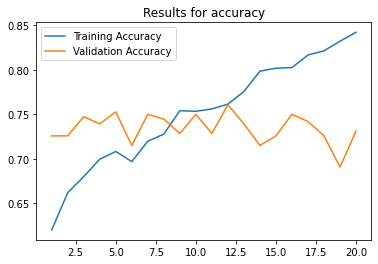

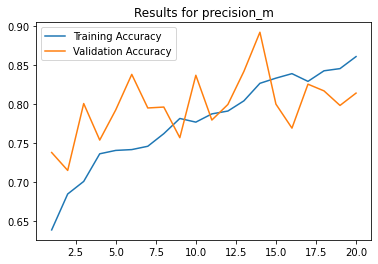

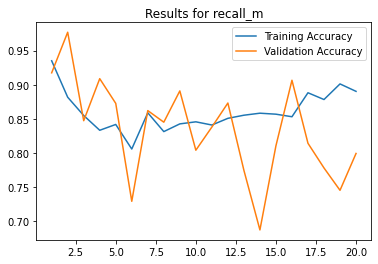

In [18]:
# Plot basic evaluation metrics across epochs
import matplotlib.pyplot as plt
%matplotlib inline

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()

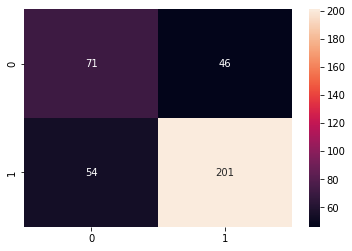

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = (model.predict(X_test_seq_padded) > 0.5).astype('int32')
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [20]:
score = model.evaluate(X_test_seq_padded, y_test, verbose=2)
print(score)

12/12 - 0s - loss: 0.5850 - accuracy: 0.7312 - precision_m: 0.8143 - recall_m: 0.7989 - 283ms/epoch - 24ms/step
[0.5850065350532532, 0.7311828136444092, 0.8142671585083008, 0.798948347568512]


Make predictions on sample sentences.

In [21]:
sentences = ["kau semua bodoh", "Aku pergi sekolah.", "Anjing aku comel."]

sequences = t.texts_to_sequences(sentences)
padded_seqs = pad_sequences(sequences, 50)

pred = model.predict(padded_seqs).reshape(-1)

pd.DataFrame({
    'Sentence': sentences,
    'Probability': pred,
    'Prediction': (pred > 0.5).astype('int')
})

,Sentence,Probability,Prediction
0,kau semua bodoh,0.993892,1
1,Aku pergi sekolah.,0.119757,0
2,Anjing aku comel.,0.355538,0


Save model to file.

In [22]:
model.save('drive/MyDrive/Colab/Hate/rnn_model')

INFO:tensorflow:Assets written to: drive/MyDrive/Colab/Hate/rnn_model/assets
